# CVIA Image Detection on SPARK dataset

`dataset.labels.iloc[1]`

Output:
```
class                            Terra
id                                6536
image              image_06536_img.png
depth            image_06536_depth.png
bbox              [476, 469, 542, 497]
illumination                  0.244364
rotation        [0.5, -0.6, -0.4, 0.5]
translation        [-3.0, -2.3, 147.9]
Name: 1, dtype: object
```

## Keras model

Source: https://keras.io/examples/vision/retinanet/

Tensorflow version: '2.3.0'

In [6]:
from utils import SPARKDataset , PyTorchSparkDataset
from matplotlib import pyplot as plt
from random import randint

import os
import re
import zipfile

import numpy as np
import tensorflow as tf
from tensorflow import keras

import pandas as pd
from skimage import io , img_as_uint
import matplotlib.patches as mpatches
from retinanet_keras_example import *
import tensorflow_datasets as tfds
# Install tfds with: conda install -c anaconda tensorflow-datasets

### Load dataset with utils.py

In [7]:
# set up the path to a local copy of the SPARK dataset, labels csv files should be in the same directory.

dataset_root_dir = 'D:/Downloads/semester_project/project_files/train_small/'#'./data/'
#dataset_root_dir = '/run/media/dave/Volume/cvia_dataset/train_small/'
split = 'rgb'
test_length = 20
dataset = SPARKDataset(root_dir=dataset_root_dir,split=split)

In [8]:
# def swap_xy(boxes):
#     return pd.concat([boxes.iloc[:, 1], boxes.iloc[:, 0], boxes.iloc[:, 3], boxes.iloc[:, 2]], axis=1)

# def convert_to_xywh(boxes):
#     width = boxes.iloc[:,2] - boxes.iloc[:,0]
#     height = boxes.iloc[:,3] - boxes.iloc[:,1]
#     x = boxes.iloc[:,0] + width / 2.0
#     y = boxes.iloc[:,1] + height / 2.0
#     return pd.concat([x, y, width, height], axis=1)

# def convert_to_corners(boxes):
#     width = boxes.iloc[:,2]
#     height = boxes.iloc[:,3]
#     xmin = boxes.iloc[:,0] - width / 2.0
#     ymin = boxes.iloc[:,1] - height / 2.0
#     xmax = boxes.iloc[:,0] + width / 2.0
#     ymax = boxes.iloc[:,1] + height / 2.0
#     return pd.concat([xmin, ymin, xmax, ymax], axis=1)

In [9]:
dataset.get_bbox(3)[1:]

(606, 692, 945)

In [10]:
len(dataset.labels)

30000

In [191]:
# class,id,image,depth,bbox,illumination,rotation,translation
labels_class = []
labels_id = []
labels_image = []
labels_depth = []
labels_bbox_xmin = []
labels_bbox_ymin = []
labels_bbox_xmax = []
labels_bbox_ymax = []
labels_bbox = []


labels_illumination = []


for i in range(test_length):
    labels_class.append(dataset.labels.iloc[i]['class'])
    labels_id.append(dataset.labels.iloc[i]['id'])
    labels_image.append(dataset.labels.iloc[i]['image'])
    labels_depth.append(dataset.labels.iloc[i]['depth'])
    labels_illumination.append(dataset.labels.iloc[i]['illumination'])
    
    labels_bbox_xmin.append(dataset.get_bbox(i)[0])
    labels_bbox_ymin.append(dataset.get_bbox(i)[1])
    labels_bbox_xmax.append(dataset.get_bbox(i)[2])
    labels_bbox_ymax.append(dataset.get_bbox(i)[3])
    labels_bbox.append(np.array([dataset.get_bbox(i)[0],
                                 dataset.get_bbox(i)[1],
                                 dataset.get_bbox(i)[2],
                                 dataset.get_bbox(i)[3]]))
    
data = {'class': labels_class,
        'id': labels_id,
        'image': labels_image,
        'depth': labels_depth,
        'illumination': labels_illumination,
       }

bbox_data = {'xmin': labels_bbox_xmin,
             'ymin': labels_bbox_ymin,
             'xmax': labels_bbox_xmax,
             'ymax': labels_bbox_ymax
            }

bbox_data = [labels_bbox_xmin,
             labels_bbox_ymin,
             labels_bbox_xmax,
             labels_bbox_ymax]

bbox_data = np.array(bbox_data)

# bbox_xywh_data = {'x': labels_bbox_x,
#                   'y': labels_bbox_y,
#                   'width': labels_bbox_width,
#                   'height': labels_bbox_height,
#                  }

label_dataframe = pd.DataFrame(data)
bbox_dataframe = pd.DataFrame(bbox_data)
# bbox_xywh_dataframe = pd.DataFrame(bbox_xywh_data)

In [192]:
label_dataframe.head()

,class,id,image,depth,illumination
0,Cloudsat,10563,image_10563_img.png,image_10563_depth.png,81.036141
1,Terra,6536,image_06536_img.png,image_06536_depth.png,0.244364
2,Sentinel-6,4676,image_04676_img.png,image_04676_depth.png,0.126758
3,Sentinel-6,2965,image_02965_img.png,image_02965_depth.png,0.686202
4,CubeSat,3907,image_03907_img.png,image_03907_depth.png,0.480803


In [193]:
len(label_dataframe)

20

In [194]:
bbox_data

array([[262, 476, 520, 377, 523, 293, 505, 406, 546, 547, 329, 149, 390,
        449, 569, 531,   0, 461, 404, 522],
       [283, 469, 445, 606, 421, 156, 508, 521, 427, 503, 598, 434, 595,
        539, 567, 455, 472, 422, 476, 452],
       [323, 542, 584, 692, 560, 392, 609, 505, 585, 679, 372, 246, 689,
        481, 627, 553, 652, 511, 749, 656],
       [367, 497, 516, 945, 464, 241, 640, 573, 511, 600, 641, 568, 721,
        596, 669, 554, 807, 507, 703, 557]])

In [195]:
bbox_dataframe.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,262,476,520,377,523,293,505,406,546,547,329,149,390,449,569,531,0,461,404,522
1,283,469,445,606,421,156,508,521,427,503,598,434,595,539,567,455,472,422,476,452
2,323,542,584,692,560,392,609,505,585,679,372,246,689,481,627,553,652,511,749,656
3,367,497,516,945,464,241,640,573,511,600,641,568,721,596,669,554,807,507,703,557


In [196]:
tf.data.Dataset.from_tensor_slices(bbox_dataframe)

<TensorSliceDataset shapes: (20,), types: tf.int32>

In [197]:
# bbox_dataframe

In [198]:
# bbox_xywh_dataframe

### Dataframe slicing

In [199]:
# bbox_dataframe.iloc[0:5,:2]

In [200]:
# bbox_dataframe.iloc[:,2:]

In [201]:
print(os.path.join(dataset.root_dir, f"{label_dataframe['class'][i]}/{label_dataframe['image'][i]}"))

D:/Downloads/semester_project/project_files/train_small/rgb\Aura/image_09134_img.png


In [202]:
def visualize(i, label_dataframe, bbox_dataframe, root_dir, size=(15,15),  ax=None, image_type='rgb'):

        """ Visualizing image, with ground truth pose with axes projected to training image. """

        if ax is None:
            ax = plt.gca()
            
        image_path = os.path.join(root_dir, f"rgb/{label_dataframe['class'][i]}/{label_dataframe['image'][i]}")
        depth_path = os.path.join(root_dir, f"depth/{label_dataframe['class'][i]}/{label_dataframe['depth'][i]}")
        
        min_x = bbox_dataframe['xmin'][i]
        min_y = bbox_dataframe['ymin'][i]
        max_x = bbox_dataframe['xmax'][i]
        max_y = bbox_dataframe['ymax'][i]
        
        
        image = io.imread(image_path)
        depth = io.imread(depth_path)

        if image_type=='rgb':
            ax.imshow(image,vmin=0, vmax=255)
            my_color = 'red'
            im_scale = 1
        elif image_type=='depth':
            ax.imshow(depth, vmin=0, vmax=255)
            my_color = 'red'
            im_scale = 0.25
        else:
            print('Incorrect parameter: image_type. Exiting function!')
            return
        
        
        min_x = bbox_dataframe['xmin'][i]
        min_y = bbox_dataframe['ymin'][i]
        max_x = bbox_dataframe['xmax'][i]
        max_y = bbox_dataframe['ymax'][i]
        rect = mpatches.Rectangle((im_scale*min_y, im_scale*min_x), im_scale*(max_y - min_y), im_scale*(max_x - min_x),
                                    fill=False, edgecolor=my_color, linewidth=2)

        ax.add_patch(rect)
        
        #label = f"{list(self.class_map.keys())[list(self.class_map.values()).index(img_class)]}"
        
        #ax.text(min_y, min_x-20, label,color='white',fontsize=15)
        ax.set_axis_off()

        return 

KeyError: 'xmin'

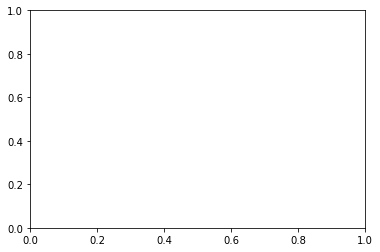

In [203]:
root_dir = '/run/media/dave/Volume/cvia_dataset/train_small/'
root_dir = 'D:/Downloads/semester_project/project_files/train_small/'
visualize(3, 
          label_dataframe,
          bbox_dataframe,
          root_dir,
          ax=None,
          size=(15,15),
          image_type='rgb')

## Create model conform dataset

Dataset should be compliant to the following form:

```python
{'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 
 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None), 
 'image/id': TensorSpec(shape=(), dtype=tf.int64, name=None), 
 'objects': 
     {'area': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 
      'bbox': TensorSpec(shape=(None, 4), dtype=tf.float32, name=None), 
      'id': TensorSpec(shape=(None,), dtype=tf.int64, name=None), 
      'is_crowd': TensorSpec(shape=(None,), dtype=tf.bool, name=None), 
      'label': TensorSpec(shape=(None,), dtype=tf.int64, name=None)
     }
}
```

In [204]:
label_dataframe.head()

,class,id,image,depth,illumination
0,Cloudsat,10563,image_10563_img.png,image_10563_depth.png,81.036141
1,Terra,6536,image_06536_img.png,image_06536_depth.png,0.244364
2,Sentinel-6,4676,image_04676_img.png,image_04676_depth.png,0.126758
3,Sentinel-6,2965,image_02965_img.png,image_02965_depth.png,0.686202
4,CubeSat,3907,image_03907_img.png,image_03907_depth.png,0.480803


#### Generate a dataframe slice with the images

In [205]:
def generate_images_frame(dataframe, root_dir):
    images = []
    image_path = os.path.join(root_dir, f"rgb/{label_dataframe['class'][i]}/{label_dataframe['image'][i]}")
    for image_name in label_dataframe['image']:
         images.append(io.imread(image_path))
    return images

dataset_images = generate_images_frame(label_dataframe, root_dir)

#### Generate the tensorflow dataframe with the respective fields

In [206]:
bbox_dataframe.iloc[:, 0]

0    262
1    283
2    323
3    367
Name: 0, dtype: int32

In [229]:
dataset_areas = []
# areas = (bbox_dataframe['xmax'] - bbox_dataframe['xmin']) * (bbox_dataframe['ymax'] - bbox_dataframe['ymin'])
areas = (bbox_dataframe.iloc[2,:] - bbox_dataframe.iloc[0,:]) * (bbox_dataframe.iloc[3,:] - bbox_dataframe.iloc[1,:])
is_crowds = []
for i in range(len(label_dataframe)):
    is_crowds.append(False)
#np.zeros(len(label_dataframe))

class_map =  {'AcrimSat':0, 'Aquarius':1, 'Aura':2, 'Calipso':3, 'Cloudsat':4, 'CubeSat':5,
                           'Debris' :6, 'Jason':7, 'Sentinel-6':8, 'Terra':9, 'TRMM':10}
remapped_labels = []
for i in range(len(label_dataframe)):
    remapped_labels.append(class_map[label_dataframe['class'][i]])
remapped_labels = np.int64(remapped_labels)

dataset_objects = {'area': areas,
                   'bbox': np.transpose(bbox_dataframe),
                   'id': label_dataframe['id'],
                   'is_crowd': is_crowds,
                   'label': remapped_labels,
                  }
tf_input_data = {'image': dataset_images, 
                 'image/filename': label_dataframe['image'], 
                 'image/id': label_dataframe['id'],
                 'objects': dataset_objects
                 }

In [230]:
len(np.transpose(bbox_dataframe))

20

In [231]:
tf_dataset = tf.data.Dataset.from_tensor_slices(tf_input_data)

In [232]:
print(tf_dataset)

<TensorSliceDataset shapes: {image: (1024, 1024, 3), image/filename: (), image/id: (), objects: {area: (), bbox: (4,), id: (), is_crowd: (), label: ()}}, types: {image: tf.int32, image/filename: tf.string, image/id: tf.int64, objects: {area: tf.int32, bbox: tf.int32, id: tf.int64, is_crowd: tf.bool, label: tf.int64}}>


10563
{'area': 5124, 'bbox': array([262, 283, 323, 367], dtype=int64), 'id': 10563, 'is_crowd': False, 'label': 4}
bbox: [262 283 323 367]


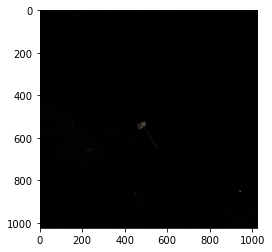

In [124]:
for element in tf_dataset.take(1).as_numpy_iterator():
    print(element['image/id'])
    print(element['objects'])
    print(f"bbox: {element['objects']['bbox']}")
    plt.imshow(element['image'])

In [125]:
# def compute_iou(boxes1, boxes2):
#     """Computes pairwise IOU matrix for given two sets of boxes

#     Arguments:
#       boxes1: A tensor with shape `(N, 4)` representing bounding boxes
#         where each box is of the format `[x, y, width, height]`.
#         boxes2: A tensor with shape `(M, 4)` representing bounding boxes
#         where each box is of the format `[x, y, width, height]`.

#     Returns:
#       pairwise IOU matrix with shape `(N, M)`, where the value at ith row
#         jth column holds the IOU between ith box and jth box from
#         boxes1 and boxes2 respectively.
#     """
#     boxes1_corners = convert_to_corners(boxes1)
#     boxes2_corners = convert_to_corners(boxes2)
#     lu = tf.maximum(boxes1.iloc[:, :2], boxes2.iloc[:, :2])
#     rd = tf.minimum(boxes1.iloc[:, 2:], boxes2.iloc[:, 2:])
#     zeros_frame = pd.DataFrame(np.zeros((len(boxes1), 1)))
#     intersection = tf.maximum(zeros_frame, rd - lu)
#     intersection_area = intersection[:, 0] * intersection[:, 1]
#     boxes1_area = boxes1.iloc[:, 2] * boxes1.iloc[:, 3]
#     boxes2_area = boxes2.iloc[:, 2] * boxes2.iloc[:, 3]
#     ones_frame = pd.DataFrame(np.ones((len(boxes1), 1)))
#     union_area = tf.maximum(
#         boxes1_area + boxes2_area - intersection_area, 1e-8 * ones_frame
#     )
#     return tf.clip_by_value(intersection_area / union_area, 0.0, 1.0)

In [126]:
# compute_iou(bbox_dataframe, bbox_dataframe)

In [127]:
# def visualize_detections(
#     image, boxes, classes, scores, figsize=(7, 7), linewidth=1, color=[0, 0, 1]
# ):
#     """Visualize Detections"""
#     image = np.array(image, dtype=np.uint8)
#     plt.figure(figsize=figsize)
#     plt.axis("off")
#     plt.imshow(image)
#     ax = plt.gca()
#     for box, _cls, score in zip(boxes, classes, scores):
#         text = "{}: {:.2f}".format(_cls, score)
#         x1, y1, x2, y2 = box
#         w, h = x2 - x1, y2 - y1
#         patch = plt.Rectangle(
#             [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
#         )
#         ax.add_patch(patch)
#         ax.text(
#             x1,
#             y1,
#             text,
#             bbox={"facecolor": color, "alpha": 0.4},
#             clip_box=ax.clipbox,
#             clip_on=True,
#         )
#     plt.show()
#     return ax

## Generate the Keras Model

Setting up training parameters:

In [128]:
model_dir = r"D:/Downloads/semester_project/project_files/retinanet/"
label_encoder = LabelEncoder()

num_classes = 11
batch_size = 2

learning_rates = [2.5e-06, 0.000625, 0.00125, 0.0025, 0.00025, 2.5e-05]
learning_rate_boundaries = [125, 250, 500, 240000, 360000]
learning_rate_fn = tf.optimizers.schedules.PiecewiseConstantDecay(
    boundaries=learning_rate_boundaries, values=learning_rates
)

Initializing and compiling model:

In [129]:
resnet50_backbone = get_backbone()
loss_fn = RetinaNetLoss(num_classes)
model = RetinaNet(num_classes, resnet50_backbone)

optimizer = tf.optimizers.SGD(learning_rate=learning_rate_fn, momentum=0.9)
model.compile(loss=loss_fn, optimizer=optimizer)

Setting up callbacks:

In [130]:
callbacks_list = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=os.path.join(model_dir, "weights" + "_epoch_{epoch}"),
        monitor="loss",
        save_best_only=False,
        save_weights_only=True,
        verbose=1,
    )
]

Load dataset as training and validation set:

In [131]:
# (train_dataset, val_dataset), dataset_info = tfds.load(
#     "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
# )

In [132]:
# Credit:
# https://towardsdatascience.com/how-to-split-a-tensorflow-dataset-into-train-validation-and-test-sets-526c8dd29438
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [133]:
train_dataset, val_dataset, test_dataset = get_dataset_partitions_tf(tf_dataset, tf_dataset.cardinality().numpy())

In [134]:
print(f"Train Data Set Size: {train_dataset.cardinality().numpy()}")
print(f"Validation Data Set Size: {val_dataset.cardinality().numpy()}")
print(f"Test Data Set Size: {test_dataset.cardinality().numpy()}")

Train Data Set Size: 16
Validation Data Set Size: 2
Test Data Set Size: 2


Set up tf.data pipeline

In [135]:
try:
    autotune = tf.data.AUTOTUNE     
except:
    autotune = tf.data.experimental.AUTOTUNE 
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
train_dataset = train_dataset.shuffle(8 * batch_size)
train_dataset = train_dataset.padded_batch(
    batch_size=batch_size, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
train_dataset = train_dataset.map(
    label_encoder.encode_batch, num_parallel_calls=autotune
)
train_dataset = train_dataset.apply(tf.data.experimental.ignore_errors())
train_dataset = train_dataset.prefetch(autotune)

val_dataset = val_dataset.map(preprocess_data, num_parallel_calls=autotune)
val_dataset = val_dataset.padded_batch(
    batch_size=1, padding_values=(0.0, 1e-8, -1), drop_remainder=True
)
val_dataset = val_dataset.map(label_encoder.encode_batch, num_parallel_calls=autotune)
val_dataset = val_dataset.apply(tf.data.experimental.ignore_errors())
val_dataset = val_dataset.prefetch(autotune)

ValueError: in user code:

    C:\Users\dvdme\OneDrive\Dokumente\cvia_course\cvia_semester_project\retinanet_keras_example.py:290 preprocess_data  *
        bbox = swap_xy(sample["objects"]["bbox"])
    C:\Users\dvdme\OneDrive\Dokumente\cvia_course\cvia_semester_project\retinanet_keras_example.py:21 swap_xy  *
        return tf.stack([boxes[:, 1], boxes[:, 0], boxes[:, 3], boxes[:, 2]], axis=-1)
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\ops\array_ops.py:1013 _slice_helper
        return strided_slice(
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\ops\array_ops.py:1186 strided_slice
        op = gen_array_ops.strided_slice(
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\ops\gen_array_ops.py:10346 strided_slice
        _, _, _op, _outputs = _op_def_library._apply_op_helper(
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\op_def_library.py:742 _apply_op_helper
        op = g._create_op_internal(op_type_name, inputs, dtypes=None,
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\func_graph.py:591 _create_op_internal
        return super(FuncGraph, self)._create_op_internal(  # pylint: disable=protected-access
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py:3477 _create_op_internal
        ret = Operation(
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py:1974 __init__
        self._c_op = _create_c_op(self._graph, node_def, inputs,
    D:\Programs\Anaconda\lib\site-packages\tensorflow\python\framework\ops.py:1815 _create_c_op
        raise ValueError(str(e))

    ValueError: Index out of range using input dim 1; input has only 1 dims for '{{node strided_slice}} = StridedSlice[Index=DT_INT32, T=DT_INT64, begin_mask=1, ellipsis_mask=0, end_mask=1, new_axis_mask=0, shrink_axis_mask=2](args_4, strided_slice/stack, strided_slice/stack_1, strided_slice/stack_2)' with input shapes: [4], [2], [2], [2] and with computed input tensors: input[3] = <1 1>.


In [5]:
from gast import gast